In [12]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier,plot_importance
from sklearn.preprocessing import LabelEncoder,StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,make_scorer,confusion_matrix,roc_auc_score,plot_confusion_matrix,plot_roc_curve
from sklearn.inspection import permutation_importance

/Users/Shuqing/.pyenv/versions/3.7.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [76]:
df=pd.read_csv(os.path.join(os.getcwd(),'data/logistic_regression/train.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/logistic_regression/test.csv'))
df.set_index('id',inplace=True)

In [14]:
# Missing values
def check_missing(df):
    flag=df.isnull().sum().any()
    if flag==True:
        total=df.isnull().sum().sort_values(ascending=False)
        percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing=pd.concat([total,percent],axis=1,keys=['total','percent'])
        
        data_type=[]
        for col in df.columns:
            dtype=df[col].dtype
            data_type.append(dtype)
        missing['Type']=data_type
        return missing
    else: 
        return (False)  

In [15]:
check_missing(df)

False

In [77]:
cat_features=df.select_dtypes(include=['object']).columns
num_features=df.select_dtypes(exclude=['object']).columns

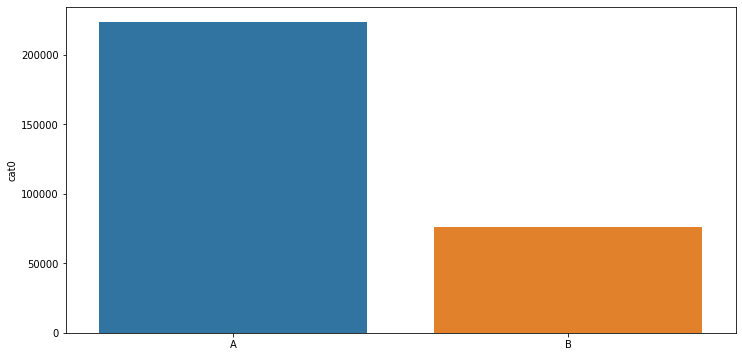

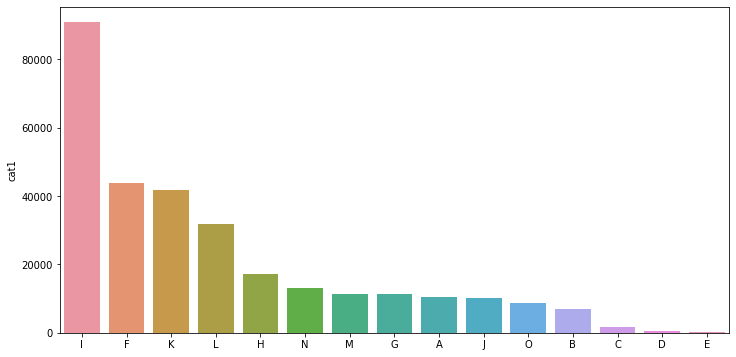

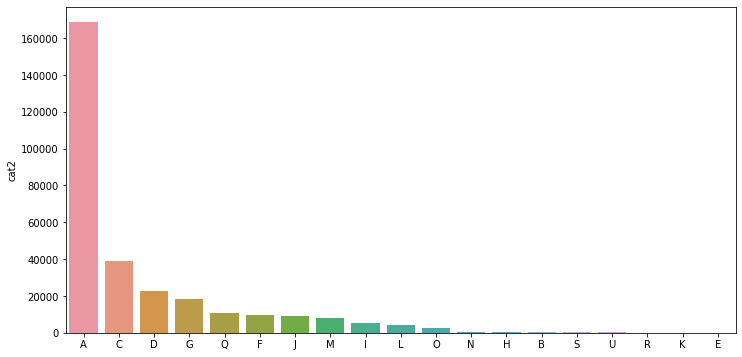

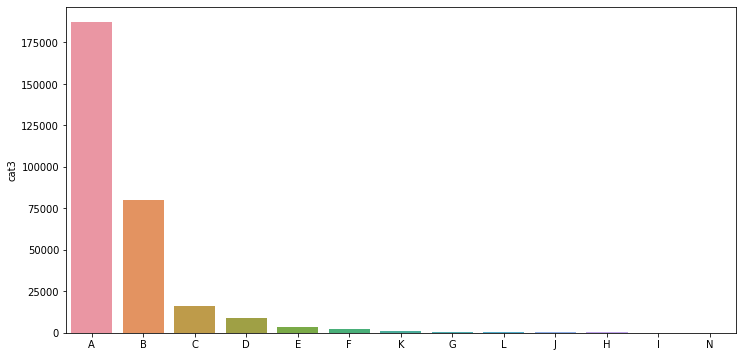

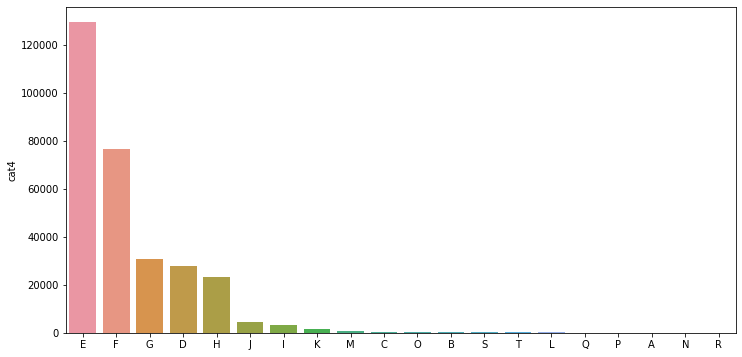

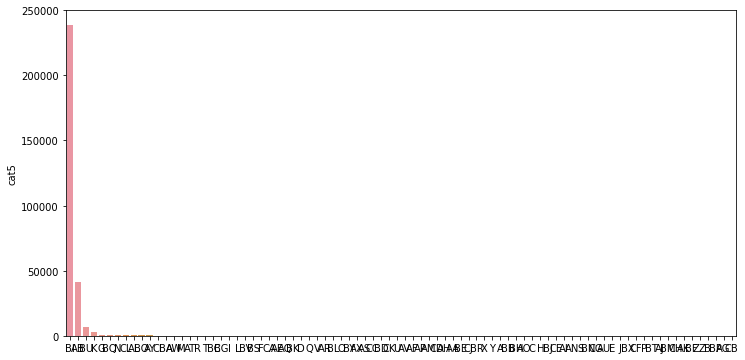

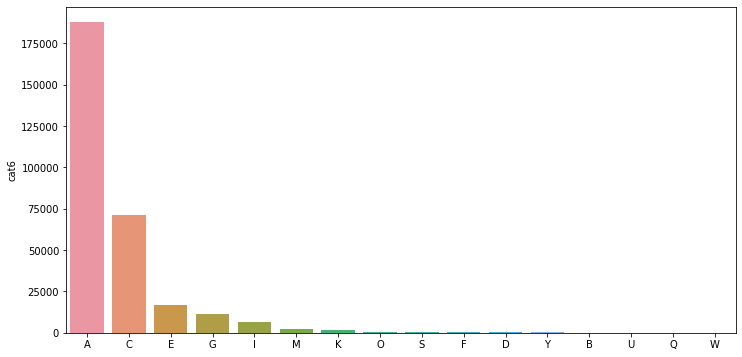

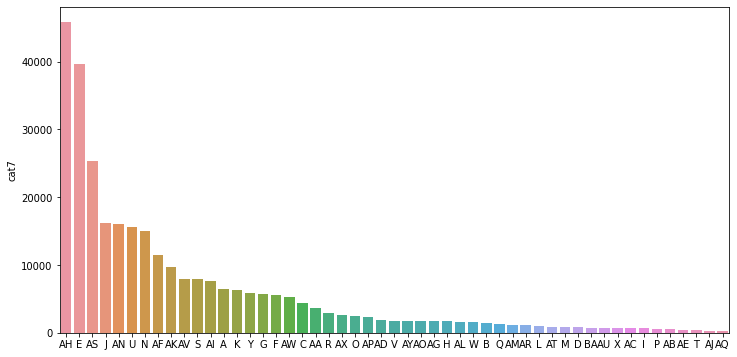

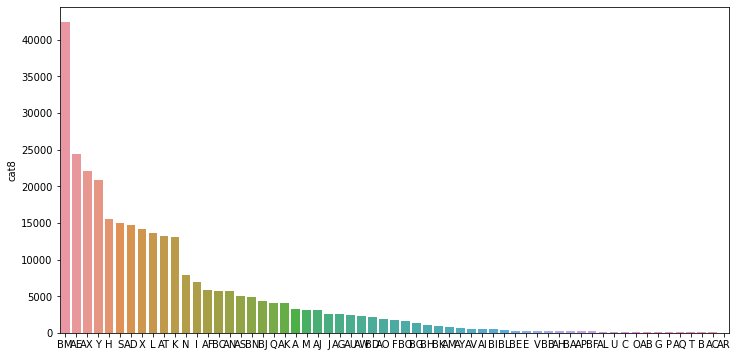

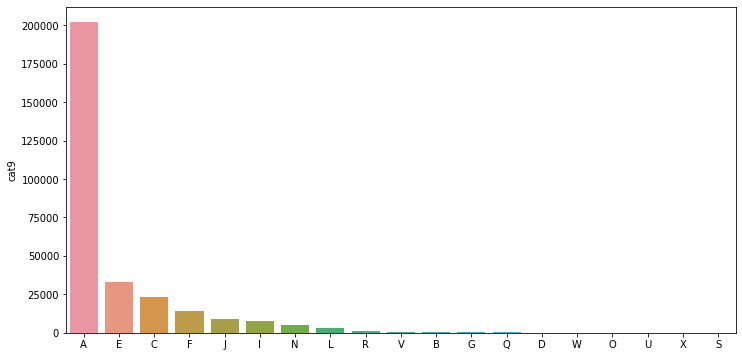

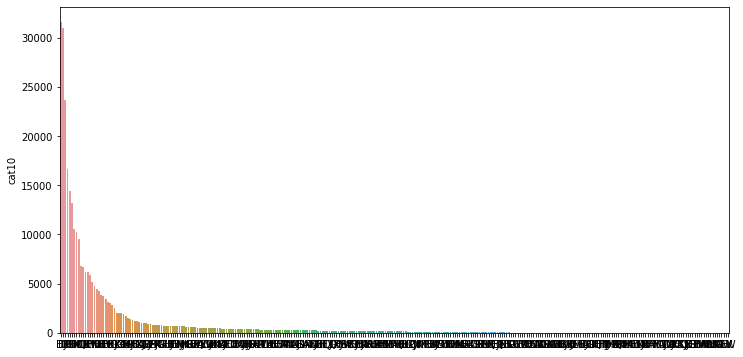

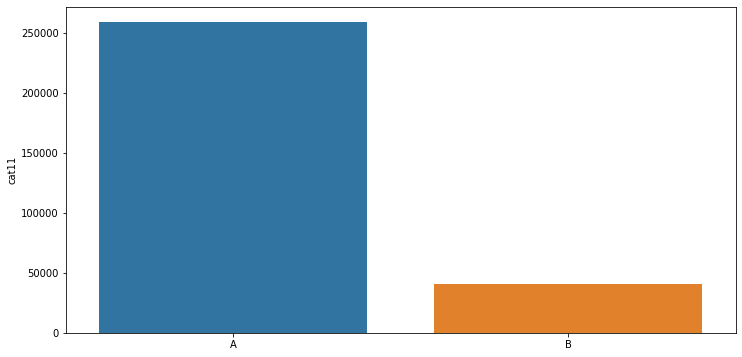

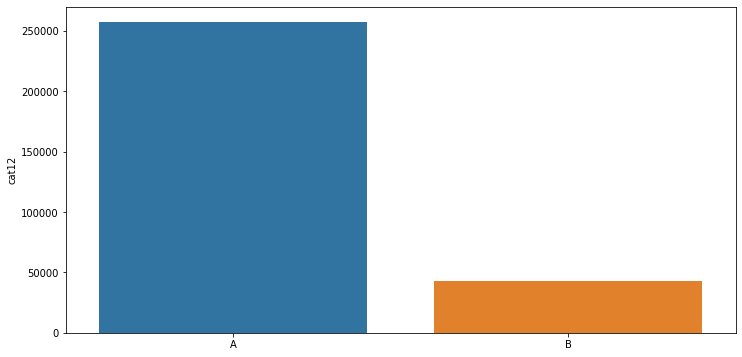

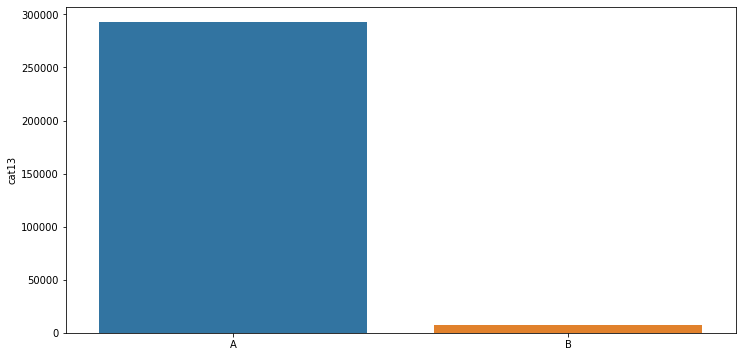

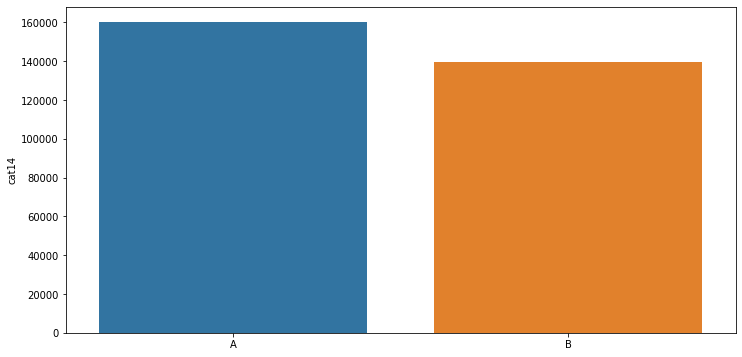

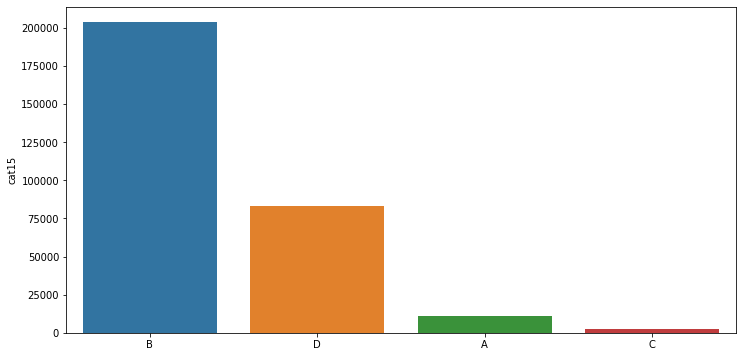

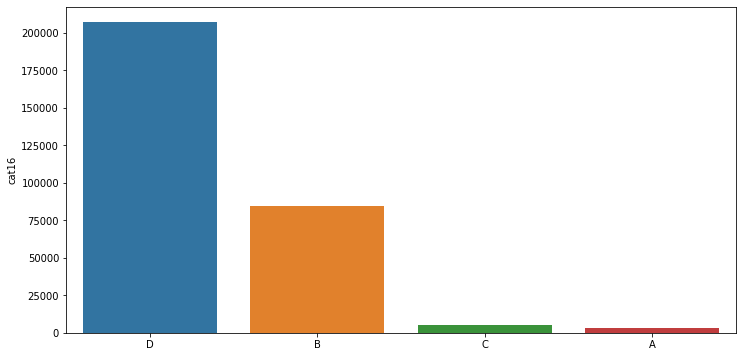

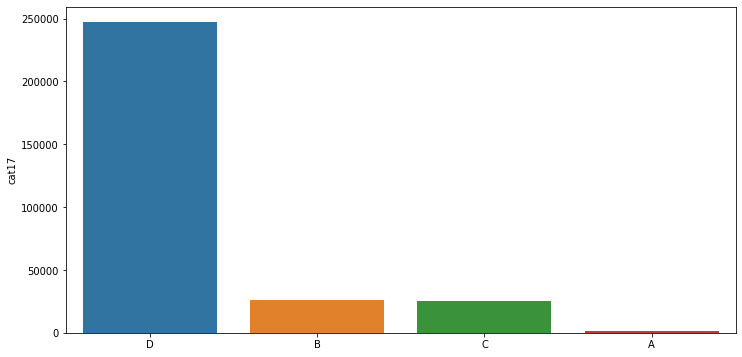

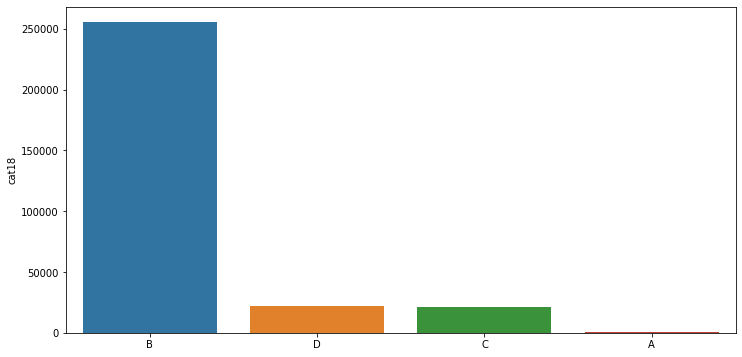

In [22]:
for i,col in enumerate(cat_features):
    f,ax=plt.subplots(figsize=(12,6))  
    sns.barplot(df[col].value_counts().index,df[col].value_counts(),ax=ax)

In [17]:
def rmse_cv_train(model):
    RMSE=np.sqrt(-cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5))
    return RMSE

In [18]:
df.target.sum()/df.target.count() # positive label percentage in the target label makeup 

0.26487

In [78]:
def split_train_valid(data,ln_train,ln_valid,random_state):
    df=data.sample(frac=1.,random_state=random_state).reset_index(drop=True)
    valid=df.iloc[-ln_valid:].reset_index(drop=True)
    train=df.iloc[:-ln_valid]
    true_y=train[train.target==1].sample(frac=0.6,random_state=random_state).reset_index(drop=True)
    non_true=train[train.target==0].head(ln_train-len(true_y))
    train=pd.concat([true_y,non_true],axis=0).sample(frac=1.,random_state=random_state).reset_index(drop=True)
    return train,valid

In [79]:

train,valid=split_train_valid(df,80000,50000,42)

In [80]:
def encode_features(df_train,df_valid,df_test):
    features=cat_features
    df_combined=pd.concat([df_train[features],df_valid[features],df_test[features]],axis=0)
    le_name_mapping=[]
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df_combined[feature])
        le_list=dict(zip(le.classes_,le.transform(le.classes_)))
        df_train[feature]=le.transform(df_train[feature])
        df_valid[feature]=le.transform(df_valid[feature])
        df_test[feature]=le.transform(df_test[feature])
        le_name_mapping.append(le_list)
    le_name_mapping=pd.Series(le_name_mapping)
    return df_train,df_valid,df_test,le_name_mapping                       

In [81]:
df_train,df_valid,df_test,le_name_mapping=encode_features(train,valid,test)

In [82]:
def split_X_y(df):
        X_train=df.drop(['target'],axis=1)
        y_train=df.target.values
        return X_train,y_train

In [83]:
X_train,y_train=split_X_y(df_train)
X_valid,y_valid=split_X_y(df_valid)

## Modelling

In [13]:
## Logisitc Regression
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_valid_pred=logreg.predict(X_valid)

In [14]:
accuracy_log=logreg.score(X_train,y_train)

In [18]:
RMSE_log=rmse_cv_train(logreg).mean()

In [23]:
coefs=pd.Series(logreg.coef_[0],index=X_train.columns).sort_values(ascending=False)

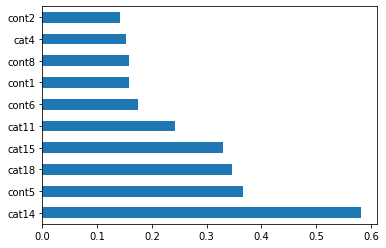

In [24]:
coefs.head(10).plot(kind='barh')

In [31]:
svc=SVC()

In [32]:
svc.fit(X_train,y_train)

SVC()

In [33]:
y_valid_pred=svc.predict(X_valid)

In [34]:
accuracy_svc=svc.score(X_train,y_train)

In [35]:
RMSE_svc=rmse_cv_train(svc).mean()

In [25]:
rf=RandomForestClassifier()

In [26]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [27]:
y_valid_pred=rf.predict(X_valid)

In [28]:
accuracy_rf=rf.score(X_train,y_train)

In [29]:
RMSE_rf=rmse_cv_train(rf).mean()

In [37]:
## According to RMSE score, RF is the best model, will fine tune both lg and rf
pd.DataFrame({'Model':['Logistic Regression','SVC','Random Forest'],
   'Score':[accuracy_log,accuracy_svc,accuracy_rf] ,
              'RMSE':[RMSE_log,RMSE_svc,RMSE_rf]})

,Model,Score,RMSE
0,Logistic Regression,0.856950,0.378790
1,SVC,0.830250,0.412007
2,Random Forest,0.999975,0.357595


## Hyperparameters Tuning For Logistic Regression

In [51]:
# pipeline=make_pipeline(StandardScaler(),LogisticRegression())
hyperparameters={'penalty':['l1','l2','elastinet'],
                 'C':[0.001,0.01,0.1,1,10,100,1000],
                 'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
                 'max_iter':list(range(100,800,100))}
acc_score=make_scorer(accuracy_score)
clf=GridSearchCV(LogisticRegression(),hyperparameters,scoring=acc_score)

In [52]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300, 400, 500, 600, 700],
                         'penalty': ['l1', 'l2', 'elastinet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring=make_scorer(accuracy_score))

In [54]:
clf.best_params_

{'C': 0.1, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}

In [55]:
clf.refit

True

In [56]:
y_pred=clf.predict(X_valid)

In [57]:
accuracy_score(y_valid,y_pred)

0.53726

In [77]:
# Probabilities for default class, 66% probabilities to be label of 1 
clf.predict_proba(X_valid)[:,1].mean()

0.6605264006761895

In [72]:
print('Q'*100)

QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ


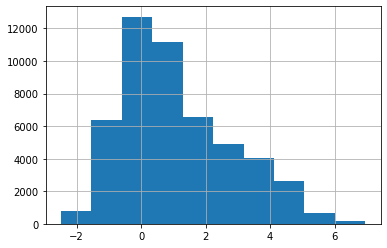

In [70]:
# QQQQQ What does this say? 
pd.Series(clf.decision_function(X_valid)).hist()

In [84]:
def check_parameters(parameters,values,fixed={},features=None):
    scores=[]
    for p in values:
        print(f'Fitting with {parameters} ={p}')
        fts = X_train.columns if features is None else features
        kw = {parameters:p,**fixed}
        model= LogisticRegression(**kw)
        %time model.fit(X_train[fts],y_train)
        y_pred=model.predict(X_valid)
        s=accuracy_score(y_valid,y_pred)
        
        print('Score',s)
        scores.append(s)
    plt.title(parameters)
    plt.plot(values,scores)

Fitting with C =0.001
CPU times: user 1.3 s, sys: 84.7 ms, total: 1.38 s
Wall time: 791 ms
Score 0.80008
Fitting with C =0.01
CPU times: user 1.35 s, sys: 75.4 ms, total: 1.42 s
Wall time: 783 ms
Score 0.79832
Fitting with C =0.1
CPU times: user 1.27 s, sys: 61.1 ms, total: 1.34 s
Wall time: 689 ms
Score 0.79812
Fitting with C =1
CPU times: user 1.25 s, sys: 58.9 ms, total: 1.31 s
Wall time: 661 ms
Score 0.79702
Fitting with C =10
CPU times: user 1.23 s, sys: 57.8 ms, total: 1.29 s
Wall time: 648 ms
Score 0.79972
Fitting with C =100
CPU times: user 1.27 s, sys: 60.1 ms, total: 1.33 s
Wall time: 674 ms
Score 0.80046


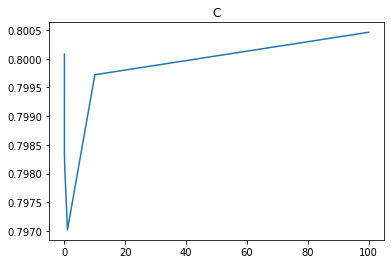

In [85]:
check_parameters('C',[0.001,0.01,0.1,1,10,100])

Fitting with solver =newton-cg
CPU times: user 3.95 s, sys: 172 ms, total: 4.13 s
Wall time: 2.23 s
Score 0.80596
Fitting with solver =lbfgs
CPU times: user 1.25 s, sys: 58.4 ms, total: 1.3 s
Wall time: 660 ms
Score 0.79972
Fitting with solver =liblinear
CPU times: user 1.57 s, sys: 34.6 ms, total: 1.6 s
Wall time: 1.5 s
Score 0.80596
Fitting with solver =sag
CPU times: user 3.65 s, sys: 23.9 ms, total: 3.68 s
Wall time: 3.58 s
Score 0.80394
Fitting with solver =saga
CPU times: user 3.43 s, sys: 33.3 ms, total: 3.47 s
Wall time: 3.37 s
Score 0.80384


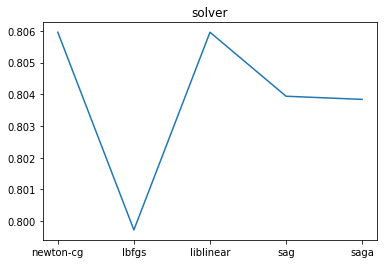

In [86]:
p='solver'
v=['newton-cg','lbfgs','liblinear','sag','saga']
f={'C':10,'penalty':'l2'}
check_parameters(p,v,f)

Fitting with max_iter =100
CPU times: user 1.52 s, sys: 25.3 ms, total: 1.55 s
Wall time: 1.57 s
Score 0.80596
Fitting with max_iter =200
CPU times: user 1.61 s, sys: 38.9 ms, total: 1.65 s
Wall time: 1.56 s
Score 0.80596
Fitting with max_iter =300
CPU times: user 1.55 s, sys: 25.3 ms, total: 1.58 s
Wall time: 1.46 s
Score 0.80596
Fitting with max_iter =400
CPU times: user 1.55 s, sys: 25.7 ms, total: 1.58 s
Wall time: 1.47 s
Score 0.80596
Fitting with max_iter =500
CPU times: user 1.55 s, sys: 25.7 ms, total: 1.58 s
Wall time: 1.47 s
Score 0.80596
Fitting with max_iter =600
CPU times: user 1.55 s, sys: 27.3 ms, total: 1.58 s
Wall time: 1.47 s
Score 0.80596
Fitting with max_iter =700
CPU times: user 1.56 s, sys: 31.3 ms, total: 1.59 s
Wall time: 1.49 s
Score 0.80596


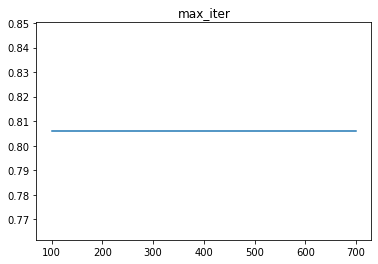

In [87]:
f={'C':10,'penalty':'l2','solver':'liblinear'}
p='max_iter'
v=list(range(100,800,100))
check_parameters(p,v,f)

In [88]:
f={'C':10,'penalty':'l2','solver':'liblinear','max_iter':100}
model=LogisticRegression(**f)
%time model.fit(X_train,y_train)

CPU times: user 1.48 s, sys: 31.4 ms, total: 1.51 s
Wall time: 1.52 s


LogisticRegression(C=10, solver='liblinear')

In [89]:
def print_score(model,X_train,X_valid,feats=None):
    if feats is not None:
        X_train,X_valid = X_train[feats],X_valid[feats]
    y_pred=model.predict(X_valid)
    RMSE_train=np.round(rmse_cv_train(model).mean(),3)
    s=accuracy_score(y_valid,y_pred)

    res = f"""
    Training RMSE :{RMSE_train}

    Validation Accuracy Score: {s}       
    """
    print(res)

In [90]:
print_score(model,X_train,X_valid)


    Training RMSE :0.456

    Validation Accuracy Score: 0.80596       
    


In [91]:
coefs=pd.Series(model.coef_[0],index=X_train.columns).sort_values(ascending=False)

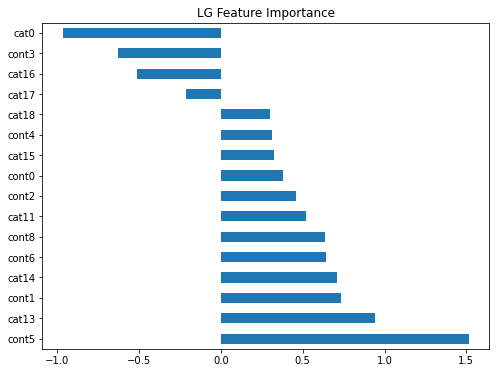

In [92]:
f,ax=plt.subplots(figsize=(8,6))
coefs[(coefs>0.15) | (coefs<-0.15)].plot(kind='barh',title='LG Feature Importance')

In [93]:
top_features=coefs[(coefs>0.15) | (coefs<-0.15)].index

In [94]:
f={'C':10,'penalty':'l2','solver':'liblinear','max_iter':100}
model=LogisticRegression(**f)
%time model.fit(X_train[top_features],y_train)

CPU times: user 343 ms, sys: 15.7 ms, total: 359 ms
Wall time: 363 ms


LogisticRegression(C=10, solver='liblinear')

In [95]:
print_score(model,X_train[top_features],X_valid[top_features]) # the score didn;t improve


    Training RMSE :0.456

    Validation Accuracy Score: 0.80456       
    


In [96]:
perm=permutation_importance(model,X_train[top_features],y_train,n_repeats=3,random_state=42)

In [97]:
perm=pd.Series(perm.importances_mean,index=X_train[top_features].columns).sort_values(ascending=False)

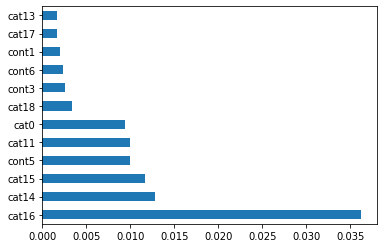

In [98]:
perm[perm>0.001].plot(kind='barh')

In [99]:
perm_features=perm[perm>0.001].index

In [100]:
f={'C':10,'penalty':'l2','solver':'liblinear','max_iter':100}
model=LogisticRegression(**f)
%time model.fit(X_train[perm_features],y_train)

CPU times: user 251 ms, sys: 19.9 ms, total: 271 ms
Wall time: 275 ms


LogisticRegression(C=10, solver='liblinear')

In [101]:
print_score(model,X_train[perm_features],X_valid[perm_features])


    Training RMSE :0.456

    Validation Accuracy Score: 0.80354       
    


In [102]:
model.predict_proba(X_valid[perm_features])[:,1].mean() # slight improvement vs CLF logistic Regression

0.4015807742536397

In [103]:
y_pred=model.predict(test[perm_features])
y_pred=pd.DataFrame({'y_pred':y_pred})

## XGBoost

In [104]:
def xg_check_parameters(parameters,values,fixed={},features=None):
    scores=[]
    for p in values:
        print(f'Fitting with {parameters} ={p}')
        fts = X_train.columns if features is None else features
        kw = {parameters:p,**fixed}
        model= XGBClassifier(**kw)
        %time model.fit(X_train[fts],y_train)
        y_pred=model.predict(X_valid)
        s=accuracy_score(y_valid,y_pred)
        
        print('Score',s)
        scores.append(s)
    plt.title(parameters)
    plt.plot(values,scores)

Fitting with n_estimators =10
CPU times: user 3.06 s, sys: 55.6 ms, total: 3.12 s
Wall time: 1.16 s
Score 0.8085
Fitting with n_estimators =20
CPU times: user 5.94 s, sys: 84.7 ms, total: 6.02 s
Wall time: 2.14 s
Score 0.81144
Fitting with n_estimators =30
CPU times: user 8.62 s, sys: 104 ms, total: 8.73 s
Wall time: 2.88 s
Score 0.81232
Fitting with n_estimators =40
CPU times: user 11.3 s, sys: 128 ms, total: 11.4 s
Wall time: 3.52 s
Score 0.81154
Fitting with n_estimators =50
CPU times: user 13.6 s, sys: 136 ms, total: 13.8 s
Wall time: 4.14 s
Score 0.81106
Fitting with n_estimators =60
CPU times: user 16.4 s, sys: 156 ms, total: 16.5 s
Wall time: 4.82 s
Score 0.81048
Fitting with n_estimators =70
CPU times: user 19.1 s, sys: 180 ms, total: 19.3 s
Wall time: 5.58 s
Score 0.81022
Fitting with n_estimators =80
CPU times: user 21.5 s, sys: 211 ms, total: 21.7 s
Wall time: 6.63 s
Score 0.81044
Fitting with n_estimators =90
CPU times: user 24.1 s, sys: 227 ms, total: 24.3 s
Wall time: 7.1

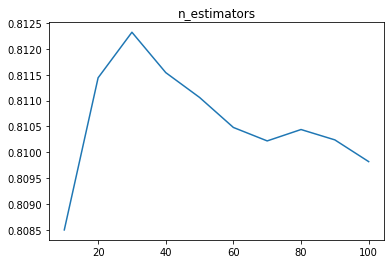

In [105]:
p='n_estimators'
v=list(range(10,110,10))
xg_check_parameters(p,v)

Fitting with max_depth =3
CPU times: user 4.33 s, sys: 50 ms, total: 4.38 s
Wall time: 1.37 s
Score 0.80924
Fitting with max_depth =5
CPU times: user 7.08 s, sys: 73.3 ms, total: 7.15 s
Wall time: 2.15 s
Score 0.8109
Fitting with max_depth =6
CPU times: user 8.37 s, sys: 110 ms, total: 8.48 s
Wall time: 2.81 s
Score 0.81232


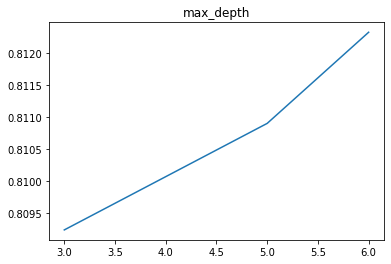

In [106]:
f={'n_estimators':30}
p='max_depth'
v=[3,5,6]
xg_check_parameters(p,v,f)

Fitting with learning_rate =0.001
CPU times: user 7.15 s, sys: 88.2 ms, total: 7.24 s
Wall time: 2.44 s
Score 0.79518
Fitting with learning_rate =0.01
CPU times: user 7.21 s, sys: 65.4 ms, total: 7.28 s
Wall time: 2.15 s
Score 0.79374
Fitting with learning_rate =0.1
CPU times: user 7.2 s, sys: 67.9 ms, total: 7.27 s
Wall time: 2.14 s
Score 0.80926
Fitting with learning_rate =10
CPU times: user 1.72 s, sys: 24.9 ms, total: 1.74 s
Wall time: 551 ms
Score 0.26082


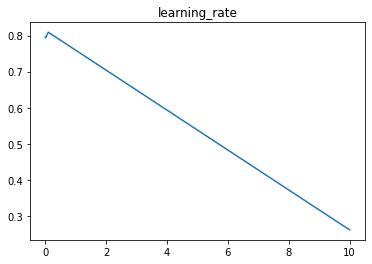

In [107]:
f={'n_estimators':30,'max_depth':5}
p = 'learning_rate'
v=[0.001,0.01,0.1,10]
xg_check_parameters(p,v,f)

Fitting with gamma =0
CPU times: user 7.31 s, sys: 80.8 ms, total: 7.39 s
Wall time: 2.2 s
Score 0.80926
Fitting with gamma =0.9
CPU times: user 7.23 s, sys: 72 ms, total: 7.3 s
Wall time: 2.25 s
Score 0.80926
Fitting with gamma =1
CPU times: user 7.21 s, sys: 68.8 ms, total: 7.28 s
Wall time: 2.13 s
Score 0.80926


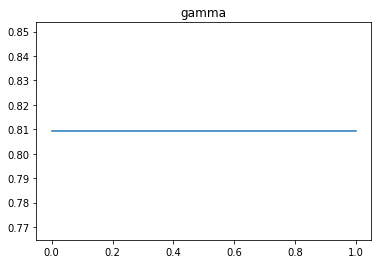

In [108]:
f={'n_estimators':30,'max_depth':5,'learning_rate':0.1,'random_state':42}
p = 'gamma'
v = [0,0.9,1]
xg_check_parameters(p,v,f)

In [109]:
f={'n_estimators':30,'max_depth':5,'learning_rate':0.1,'random_state':42,'gamma':0.9}
model=XGBClassifier(**f)
%time model.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_valid,y_valid)],eval_metric=["auc", "error", "error@0.6"])

[0]	validation_0-auc:0.85479	validation_0-error:0.20496	validation_0-error@0.6:0.26082
Multiple eval metrics have been passed: 'validation_0-error@0.6' will be used for early stopping.

Will train until validation_0-error@0.6 hasn't improved in 5 rounds.
[1]	validation_0-auc:0.85842	validation_0-error:0.20562	validation_0-error@0.6:0.26082
[2]	validation_0-auc:0.86159	validation_0-error:0.20848	validation_0-error@0.6:0.18632
[3]	validation_0-auc:0.86396	validation_0-error:0.19322	validation_0-error@0.6:0.16554
[4]	validation_0-auc:0.86498	validation_0-error:0.19636	validation_0-error@0.6:0.16216
[5]	validation_0-auc:0.86652	validation_0-error:0.19538	validation_0-error@0.6:0.16298
[6]	validation_0-auc:0.86706	validation_0-error:0.19512	validation_0-error@0.6:0.16398
[7]	validation_0-auc:0.86774	validation_0-error:0.19630	validation_0-error@0.6:0.16408
[8]	validation_0-auc:0.86871	validation_0-error:0.19642	validation_0-error@0.6:0.16408
[9]	validation_0-auc:0.86906	validation_0-error:0

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.9, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [110]:
def xg_print_score(model,X_train,X_valid,feats=None):
    if feats is not None:
        X_train,X_valid = X_train[feats],X_valid[feats]
    y_pred=model.predict(X_valid)
    roc_auc_train=roc_auc_score(y_train==1,model.predict_proba(X_train)[:,1])
    roc_auc_valid = roc_auc_score(y_valid==1,model.predict_proba(X_valid)[:,1])
    tn,fp,fn,tp=confusion_matrix(y_valid,y_pred).ravel()
    recall = tp/(tp+fn)
    precision=tp/(tp+fp)
    res=f"""
    Training ROC_AUC :{roc_auc_train}
    
    Validation ROC_AUC :{roc_auc_valid}
    
    Recall :{recall}
    Precision:{precision}
    
    """
    print(res)
    
    plot_roc_curve(model,X_valid,y_valid)
    plot_confusion_matrix(model,X_valid,y_valid)
    return plot_importance(model)
    


    Training ROC_AUC :0.8662048595945278
    
    Validation ROC_AUC :0.8649750583485616
    
    Recall :0.7513227513227513
    Precision:0.5984242350210712
    
    


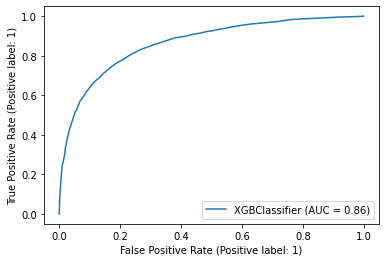

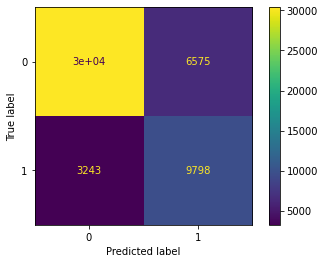

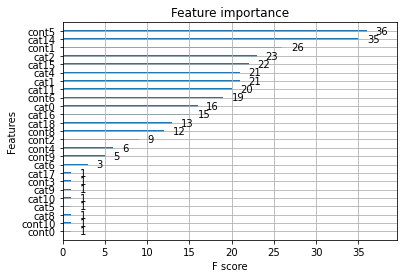

In [111]:
xg_print_score(model,X_train,X_valid) ## not too bad for both recall and precision 

In [116]:
top_xg_features=pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
top_xg_features=top_xg_features[top_xg_features>0.01].index

In [125]:
f={'n_estimators':30,'max_depth':5,'learning_rate':0.1,'random_state':42,'gamma':0.9}
model=XGBClassifier(**f)
%time model.fit(X_train[top_xg_features],y_train,early_stopping_rounds=5,eval_set=[(X_valid[top_xg_features],y_valid)],eval_metric=["auc", "error", "error@0.6"])

[0]	validation_0-auc:0.85456	validation_0-error:0.20588	validation_0-error@0.6:0.26082
Multiple eval metrics have been passed: 'validation_0-error@0.6' will be used for early stopping.

Will train until validation_0-error@0.6 hasn't improved in 5 rounds.
[1]	validation_0-auc:0.85784	validation_0-error:0.20622	validation_0-error@0.6:0.26082
[2]	validation_0-auc:0.85984	validation_0-error:0.20802	validation_0-error@0.6:0.19574
[3]	validation_0-auc:0.86119	validation_0-error:0.19766	validation_0-error@0.6:0.16542
[4]	validation_0-auc:0.86286	validation_0-error:0.19854	validation_0-error@0.6:0.16368
[5]	validation_0-auc:0.86343	validation_0-error:0.19496	validation_0-error@0.6:0.16368
[6]	validation_0-auc:0.86409	validation_0-error:0.19626	validation_0-error@0.6:0.16362
[7]	validation_0-auc:0.86510	validation_0-error:0.19630	validation_0-error@0.6:0.16450
[8]	validation_0-auc:0.86545	validation_0-error:0.19504	validation_0-error@0.6:0.16522
[9]	validation_0-auc:0.86562	validation_0-error:0

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.9, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


    Training ROC_AUC :0.8644118022350725
    
    Validation ROC_AUC :0.8640891513698867
    
    Recall :0.7477187332259796
    Precision:0.5991766007127934
    
    


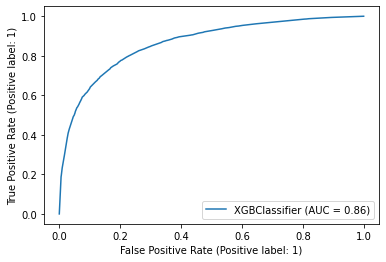

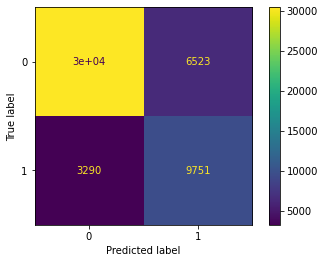

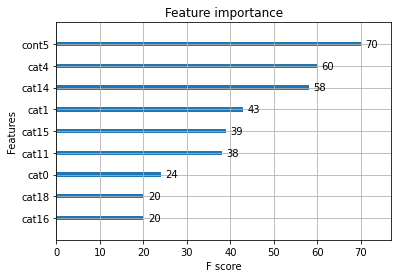

In [126]:
xg_print_score(model,X_train,X_valid,top_xg_features) ## same scores 

In [138]:
xg_y_pred=model.predict(test[top_xg_features])

In [141]:
results=pd.DataFrame({'xg_y_pred':xg_y_pred,'logstic_y_pred':y_pred.values[:,0]})

In [149]:
results[results.xg_y_pred!=results.logstic_y_pred] # predictions discrepancies 

,xg_y_pred,logstic_y_pred
8,1,0
12,1,0
14,0,1
37,1,0
73,1,0
...,...,...
199914,0,1
199929,1,0
199937,1,0
199956,1,0
